# Classification of Melanoma, Nevus and Seborrheic Keratosis with Convolutional Neural Networks

In this notebook, I will tackle Disease Classification, the third challenge of the [ISIC 2017: Skin Lesion Analysis Towards Melanoma Detection](https://challenge.kitware.com/#challenge/583f126bcad3a51cc66c8d9a). The challenge was about classifying skin lesion images into three classes: malignant melanoma (MM), nevus and seborrheic keratosis (SK). The former is the deadliest one, while nevus and seborrheic keratosis are benign forms of lesions.

The first part will consist of creating a malignant melanoma classifier using transfer learning with a pretrained ResNet152. On the second part I will create a classifier for seborrheic keratosis, also using transfer learning, and use these two classifiers to classify the 3 classes.

DISCLAMER: I'm not the owner of the dataset. Therefore, I don't include it along this notebook. It can be downloaded on the ISIC website of the challenge.

## Skin lesion images dataset

The provided dataset contains training 2000 images, 150 for validation purposes and 600 images for testing and submitting your model's performance.

More specifically we have this distribution:

- Train
  - 374 Melanoma
  - 1372 Nevus
  - 254 Seborrheic keratosis

- Valid
  - 30 Melanoma
  - 78 Nevus
  - 42 Seborrheic keratosis
  
- Test
  - 117 Melanoma
  - 393 Nevus
  - 90 Seborrheic keratosis

In [1]:
import numpy as np
from glob import glob


def count_images(set_name):
    print('{} {}\t\t {} melanoma\t {} nevus\t {} seborrheic keratosis'.format(
        np.array(glob(f"data/{set_name}/*/*")).shape[0],
        set_name,
        np.array(glob(f"data/{set_name}/melanoma/*")).shape[0],
        np.array(glob(f"data/{set_name}/nevus/*")).shape[0],
        np.array(glob(f"data/{set_name}/seborrheic_keratosis/*")).shape[0],
        ))


count_images('train')
count_images('valid')
count_images('test')

2000 train		 374 melanoma	 1372 nevus	 254 seborrheic keratosis
150 valid		 30 melanoma	 78 nevus	 42 seborrheic keratosis
600 test		 117 melanoma	 393 nevus	 90 seborrheic keratosis


## Defining transforms and dataloaders

I use the ImageFolder class from pytorch's torchvision.datasets module to import the images. ImageFolder is very handy, because it labels the images based on the name of the folder the are in. However, this is not exactly what I need. As far as I am tryining to classify malignant melanoma vs the rest, I don't need two separate labels for nevus and SK. Instead, what I need is to label them as a single class "rest". As a result, I import the function *make_dataset* from torchvision module and I provide the mapping of classes that fits to my goal.

It is worth mentioning a new requirement for the testing dataloader. Here, a new class is defined. The submitting format of the CSV of predictions demands to include the path of the image. The ImageFolder class returns the image as a tensor and the label. Nevertheless, it does not return the path to the image. To solve this problem I am defining a new class that extends from Dataset and implements all the functionality of the ImageFolder class. After that, I redefine the method that implements the population of items to provide the behaviour that I want, returning not only the image and the label, but also its path.

In [2]:
import os, sys, torch
from torchvision.datasets.folder import make_dataset, has_file_allowed_extension, default_loader, IMG_EXTENSIONS


class CustomImageFolder(torch.utils.data.Dataset):

    def __init__(self, root, transform=None, target_transform=None,
                 loader=default_loader, custom_class_to_idx=None):
        extensions = IMG_EXTENSIONS
        
        classes, class_to_idx = self._find_classes(root)
        
        if custom_class_to_idx is not None:
            self.class_to_idx = custom_class_to_idx
        else:
            self.class_to_idx = class_to_idx
        
        samples = make_dataset(root, self.class_to_idx, extensions)
        if len(samples) == 0:
            raise(RuntimeError("Found 0 files in subfolders of: " + root + "\n"
                               "Supported extensions are: " + ",".join(extensions)))

        self.root = root
        self.loader = loader
        self.extensions = extensions

        self.classes = classes
        self.samples = samples
        self.targets = [s[1] for s in samples]

        self.transform = transform
        self.target_transform = target_transform
        
        self.imgs = self.samples

    def _find_classes(self, dir):
        """
        Finds the class folders in a dataset.
        Args:
            dir (string): Root directory path.
        Returns:
            tuple: (classes, class_to_idx) where classes are relative to (dir), and class_to_idx is a dictionary.
        Ensures:
            No class is a subdirectory of another.
        """
        if sys.version_info >= (3, 5):
            # Faster and available in Python 3.5 and above
            classes = [d.name for d in os.scandir(dir) if d.is_dir()]
        else:
            classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
        classes.sort()
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        return classes, class_to_idx

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target, path

    def __len__(self):
        return len(self.samples)

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str

### Transforms and Dataloaders hyperparameters

In order to augment the data, we will perform transformations of the images (resizing, cropping, rotations, flipping). This step will allow for the network to generalize better, in addition of providing more samples by tweaking the ones we possess.

- Resizing: this parameter is an important one. It will determine the number of units our classifier will have. As a result, it cannot be changes after the network is trained, or we will have to redefine the arquitecture and train from the beginning.
- Random rotation: As far as we are training to classify skin lessions and not cats and dogs, the orientation of the image does not actually matter. Therefore, a random rotation up to 359 degrees is defined.
- Flipping: both horizontal and vertical flipping will help us augment the data.

The normalizing transform is necessary because we are using a ResNet for transfer learning. The images used for training this CNN were normalized using those parameters and therefore, it is necessary to apply them to get the best results.

The following code can be run multiple times to get a sense of the image sizes in the dataset. When choosing a resize value for the transform, we want a value that is enough for the network to pick up the details but not so high that it takes too much time to train and low resolution images are upscaled too much.

In [5]:
# Get a sense of the images size by running this cell multiple times

from PIL import Image

files = np.array(glob('data/train/*/*'))
file = files[np.random.randint(0, files.shape[0])]
image = Image.open(file)
image.size

(2592, 1936)

- img_size: After running the cell above several times, I decide a size of 448 pixels should be enough.
- num_cores: this parameter is used by the transformers and should be less or equal to the number of cores of your CPU for best performance.
- batch_size: the batch_size will depend on the memory you have available and how much of a bottleneck your CPU is to your GPU. 128 works well for me and is enough for the network to generalize.

### Defining transforms

Several things are going on in the cell below so I will explain part by part.

First of all, we define the transform pipelines. There are two. One for training, with transformations to augment the data, and one for validating and testing, which does not perform any transformation. The former will augment the images by cropping, rotating and flipping them, while the latter only has the mandatory transformations for feeding the image to the network: resizing to a fixed size, transforming the PIL Image to a PyTorch tensor and noramlizing with the values of ResNet.

After this step, we are ready to load the data.

In [3]:
from torchvision import transforms

img_size = 448

transforms = {
    'training': transforms.Compose([
        transforms.RandomResizedCrop(img_size),
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],
                             std = [0.229, 0.224, 0.225]),
    ]),
    'testing': transforms.Compose([
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],
                             std = [0.229, 0.224, 0.225]),
    ])
}

## Malignant melanoma model

### Defining dataloaders

In [4]:
from torch.utils.data import DataLoader

batch_size = 128
num_cores = 8
class_to_idx = {'melanoma': 1, 'nevus': 0, 'seborrheic_keratosis': 0}

data_loaders = {
    'train': DataLoader(
        CustomImageFolder("data/train/",
                          transform = transforms['training'],
                          custom_class_to_idx = class_to_idx),
        batch_size = batch_size,
        shuffle = True,
        num_workers = num_cores),
    'valid': DataLoader(
        CustomImageFolder("data/valid/",
                          transform = transforms['testing'],
                          custom_class_to_idx = class_to_idx),
        batch_size = batch_size,
        num_workers = num_cores),
    'test': DataLoader(
        CustomImageFolder("data/test/",
                          transform = transforms['testing'],
                          custom_class_to_idx = class_to_idx),
        batch_size = 1, num_workers = num_cores)   
}

Checking if a GPU is available

In [6]:
import torch

cuda_is_available = torch.cuda.is_available()

### Model definition

Here I download the pretrained ResNet50 model. As far as we are applying transfer learning, I freeze the weights of the convolutional network and redefine the classifier to output only two classes: malignant melanoma or rest.

In [7]:
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

In [8]:
# ResNet152
MM_model = models.resnet152(pretrained=True)
for param in MM_model.parameters():
    param.requires_grad = False
MM_model.fc = nn.Sequential(
    nn.Linear(MM_model.fc.in_features, 2)
  )

# ResNet50
# MM_model = models.resnet50(pretrained=True)
# # for param in MM_model.parameters():
# #     param.requires_grad = False
# MM_model.fc = nn.Sequential(
#     nn.Linear(MM_model.fc.in_features, 2)
#   )

# ResNet18
# MM_model = models.resnet18(pretrained=True)
# for param in MM_model.parameters():
#     param.requires_grad = False
# # for param in MM_model.layer4.parameters():
# #     requires_grad = True
# MM_model.fc = nn.Linear(MM_model.fc.in_features, 2)


MM_model_filename = 'models/MM_model_resnet152.pt'

### Training

The training and testing function have been moved to an external python file to keep the notebook more clean. Feel free to take a look at how they work.

I am using a CrossEntropyLoss criterion for this classification task and an Adam optimizer for its adaptative properties.

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

try:
    MM_model.load_state_dict(torch.load(MM_model_filename, map_location=torch.device('cpu')))
except FileNotFoundError:
    pass

# Move to GPU if available
if cuda_is_available:
    MM_model = MM_model.cuda()

modelParameters = [
    {'params': MM_model.fc.parameters()},
]

optimizer = optim.Adam(modelParameters, lr=1e-5)
# optimizer = optim.Adadelta(modelParameters, lr=1e-1)
# optimizer = optim.Adagrad(modelParameters, lr=1e-6)

In [ ]:
try:
    valid_loss_min
except NameError:
    valid_loss_min = np.Inf

In [ ]:
from net_functions import train

epochs = 200
valid_loss_min = train(epochs, data_loaders, MM_model, optimizer, criterion, cuda_is_available, MM_model_filename,
                       valid_loss_min)

## Seborrheic Keratosis model

### Defining dataloaders

In [10]:
batch_size = 128
num_cores = 8
class_to_idx = {'melanoma': 0, 'nevus': 0, 'seborrheic_keratosis': 1}

data_loaders = {
    'train': DataLoader(
        CustomImageFolder("data/train/",
                          transform = transforms['training'],
                          custom_class_to_idx = class_to_idx),
        batch_size = batch_size,
        shuffle = True,
        num_workers = num_cores),
    'valid': DataLoader(
        CustomImageFolder("data/valid/",
                          transform = transforms['testing'],
                          custom_class_to_idx = class_to_idx),
        batch_size = batch_size,
        num_workers = num_cores),
    'test': DataLoader(
        CustomImageFolder("data/test/",
                          transform = transforms['testing'],
                          custom_class_to_idx = class_to_idx),
        batch_size = 1, num_workers = num_cores)   
}

### Model definition

In [11]:
# ResNet152
SK_model = models.resnet152(pretrained=True)
for param in SK_model.parameters():
    param.requires_grad = False
SK_model.fc = nn.Sequential(
    nn.Linear(SK_model.fc.in_features, 2)
  )


SK_model_filename = 'models/SK_model_resnet152.pt'

### Training

In [15]:
criterion = nn.CrossEntropyLoss()

try:
    SK_model.load_state_dict(torch.load(SK_model_filename, map_location=torch.device('cpu')))
except FileNotFoundError:
    pass

# Move to GPU if available
if cuda_is_available:
    SK_model = SK_model.cuda()

modelParameters = [
    {'params': SK_model.fc.parameters()},
]

optimizer = optim.Adam(modelParameters, lr=1e-5)
# optimizer = optim.Adadelta(modelParameters, lr=1e-1)
# optimizer = optim.Adagrad(modelParameters, lr=1e-6)

In [16]:
try:
    valid_loss_min
except NameError:
    valid_loss_min = np.Inf

In [ ]:
from net_functions import train

epochs = 200
valid_loss_min = train(epochs, data_loaders, SK_model, optimizer, criterion, cuda_is_available, SK_model_filename,
                       valid_loss_min)

## Testing

To test the models we will load the ones which got the best validation loss, move them to GPU if available and run the test dataloader for them to generate a `predictions.csv` file containing the output of the models in the format needed to compare it to the ground truth and compute the ROC curve.

In [ ]:
from net_functions import test_to_csv

# load the models that got the best validation accuracy
try:
    MM_model.load_state_dict(torch.load(MM_model_filename, map_location=torch.device('cpu')))
    SK_model.load_state_dict(torch.load(SK_model_filename, map_location=torch.device('cpu')))
except FileNotFoundError:
    pass

if cuda_is_available:
    MM_model = MM_model.cuda()
    SK_model = SK_model.cuda()

test_to_csv(data_loaders, MM_model, SK_model, cuda_is_available)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:87: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


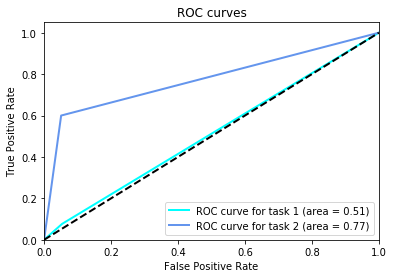

Category 1 Score: 0.512
Category 2 Score: 0.775
Category 3 Score: 0.643


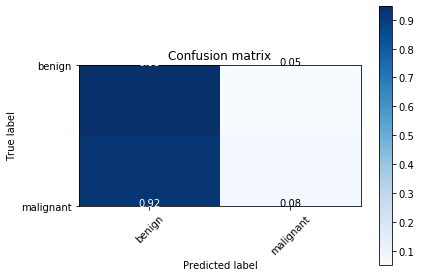

In [20]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

from sklearn.metrics import roc_curve, auc, confusion_matrix

def plot_roc_auc(y_true, y_pred):
    """
    This function plots the ROC curves and provides the scores.
    """

    # initialize dictionaries and array
    fpr = dict()
    tpr = dict()
    roc_auc = np.zeros(3)
    
    # prepare for figure
    plt.figure()
    colors = ['aqua', 'cornflowerblue']

    # for both classification tasks (categories 1 and 2)
    for i in range(2):
        # obtain ROC curve
        fpr[i], tpr[i], _ = roc_curve(y_true[:,i], y_pred[:,i])
        # obtain ROC AUC
        roc_auc[i] = auc(fpr[i], tpr[i])
        # plot ROC curve
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
                 label='ROC curve for task {d} (area = {f:.2f})'.format(d=i+1, f=roc_auc[i]))
    # get score for category 3
    roc_auc[2] = np.average(roc_auc[:2])
    
    # format figure
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves')
    plt.legend(loc="lower right")
    plt.show()
    
    # print scores
    for i in range(3):
        print('Category {d} Score: {f:.3f}'. format(d=i+1, f=roc_auc[i]))

def plot_confusion_matrix(y_true, y_pred, thresh, classes):
    """
    This function plots the (normalized) confusion matrix.
    """

    # obtain class predictions from probabilities
    y_pred = (y_pred>=thresh)*1
    # obtain (unnormalized) confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # normalize confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

thresh = 0.5

truth = pd.read_csv('ground_truth.csv')
y_true = truth.as_matrix(columns=["task_1", "task_2"])

# get model predictions for test dataset
y_pred = pd.read_csv('predictions.csv')
y_pred = y_pred.as_matrix(columns=["task_1", "task_2"])

# plot ROC curves and print scores
plot_roc_auc(y_true, y_pred)
# plot confusion matrix
classes = ['benign', 'malignant']
plot_confusion_matrix(y_true[:,0], y_pred[:,0], thresh, classes)

## Conclusions

As expected, the task of classifying MM turns out to be much harder than classifying SK.

Despite lots of trials with different pretrained models and different training hyperparameters, I was not able to get the MM score above 0.512. On the other hand, the SK vs rest classifier performs much better with a score of 0.775 and could probably be improved with more training and patience.

## Further steps

Lots of things could be done to improve this result. To start with, I could try to gather more images from the ISIC website directly. Even though the provided dataset for the challenge was big in terms of what melanoma datasets usually are, it doesn't seem to be enough for a normal model with a normal training process to generalize.

Additionally, an ensemble of models technique could be implemented to take advantage of different models.

Although in this notebook we only looked at images, the challenge also provided some other data like age and sex. This has been proven to give a little push to the ensemble predictions in this paper [Image Classification of Melanoma, Nevus and Seborrheic Keratosis
by Deep Neural Network Ensemble](https://arxiv.org/ftp/arxiv/papers/1703/1703.03108.pdf)